http://outlace.com/Reinforcement-Learning-Part-2/

In [1]:
import math
import random

## Blackjack Game

### Prepare for game

In [2]:
def randomCard():
    card = random.randint(1,13)
    if card > 10:
        card = 10
    return card

#A hand is just a tuple e.g. (14, False), a total card value of 14 without a useable ace
#accepts a hand, if the Ace can be an 11 without busting the hand, it's useable
def useable_ace(hand):
    val, ace = hand
    return ((ace) and ((val + 10) <= 21))

def totalValue(hand):
    val, ace = hand
    if (useable_ace(hand)):
        return (val + 10)
    else:
        return val

def add_card(hand, card):
    val, ace = hand
    if (card == 1):
        ace = True
    return (val + card, ace)

#The first is first dealt a single card, this method finishes off his hand
def eval_dealer(dealer_hand):
    while (totalValue(dealer_hand) < 17):
        dealer_hand = add_card(dealer_hand, randomCard())
    return dealer_hand

#state: (player total, useable_ace), (dealer total, useable ace), game status; e.g. ((15, True), (9, False), 1)
#stay or hit => dec == 0 or 1
def play(state, dec):
    #evaluate
    player_hand = state[0] #val, useable ace
    dealer_hand = state[1]
    if dec == 0: #action = stay
        #evaluate game; dealer plays
        dealer_hand = eval_dealer(dealer_hand)

        player_tot = totalValue(player_hand)
        dealer_tot = totalValue(dealer_hand)
        status = 1
        if (dealer_tot > 21):
            status = 2 #player wins
        elif (dealer_tot == player_tot):
            status = 3 #draw
        elif (dealer_tot < player_tot):
            status = 2 #player wins
        elif (dealer_tot > player_tot):
            status = 4 #player loses

    elif dec == 1: #action = hit
        #if hit, add new card to player's hand
        player_hand = add_card(player_hand, randomCard())
        d_hand = eval_dealer(dealer_hand)
        player_tot = totalValue(player_hand)
        status = 1
        if (player_tot == 21):
            if (totalValue(d_hand) == 21):
                status = 3 #draw
            else:
                status = 2 #player wins!
        elif (player_tot > 21):
            status = 4 #player loses
        elif (player_tot < 21):
            #game still in progress
            status = 1
    state = (player_hand, dealer_hand, status)

    return state

#start a game of blackjack, returns a random initial state
def initGame():
    status = 1 #1=in progress; 2=player won; 3=draw; 4 = dealer won/player loses
    player_hand = add_card((0, False), randomCard())
    player_hand = add_card(player_hand, randomCard())
    dealer_hand = add_card((0, False), randomCard())
    #evaluate if player wins from first hand
    if totalValue(player_hand) == 21:
        if totalValue(dealer_hand) != 21:
            status = 2 #player wins after first deal!
        else:
            status = 3 #draw

    state = (player_hand, dealer_hand, status)
    return state

### Lets play game

In [25]:
state = initGame()
print(state)

((14, False), (4, False), 1)


In [26]:
state = play(state, 1) #Player has total of 14, let's hit
print(state)

((24, False), (4, False), 4)


## RL

### Setting Functions

In [27]:
import numpy as np

#Create a list of all the possible states
def initStateSpace():
    states = []
    for card in range(1,11):
        for val in range(11,22):
            states.append((val, False, card))
            states.append((val, True, card))
    return states

#Create a dictionary (key-value pairs) of all possible state-actions and their values
#This creates our Q-value look up table
def initStateActions(states):
    av = {}
    for state in states:
        av[(state, 0)] = 0.0
        av[(state, 1)] = 0.0
    return av

#Setup a dictionary of state-actions to record how many times we've experienced
#a given state-action pair. We need this to re-calculate reward averages
def initSAcount(stateActions):
    counts = {}
    for sa in stateActions:
        counts[sa] = 0.
    return counts

#This calculates the reward of the game, either +1 for winning, 0 for draw, or -1 for losing
#We can determine this by simply substracting the game status value from 3
def calcReward(outcome):
    return 3.-outcome

#This recalculates the average rewards for our Q-value look-up table
def updateQtable(av_table, av_count, returns):
    for key in returns:
        av_table[key] = av_table[key] + (1. / av_count[key]) * (returns[key]- av_table[key])
    return av_table

#returns Q-value/avg rewards for each action given a state
def qsv(state, av_table):
    stay = av_table[(state,0)]
    hit = av_table[(state,1)]
    return np.array([stay, hit])

#converts a game state of the form ((player total, ace), (dealer total, ace), status) 
#to a condensed state we'll use for our RL algorithm (player total, usable ace, dealer card)
def getRLstate(state):
    player_hand, dealer_hand, status = state
    player_val, player_ace = player_hand
    return (player_val, player_ace, dealer_hand[0])

In [33]:
av_table

{((11, False, 1), 0): 0.0,
 ((11, False, 1), 1): 0.0,
 ((11, False, 2), 0): 0.0,
 ((11, False, 2), 1): 0.0,
 ((11, False, 3), 0): 0.0,
 ((11, False, 3), 1): 0.0,
 ((11, False, 4), 0): 0.0,
 ((11, False, 4), 1): 0.0,
 ((11, False, 5), 0): 0.0,
 ((11, False, 5), 1): 0.0,
 ((11, False, 6), 0): 0.0,
 ((11, False, 6), 1): 0.0,
 ((11, False, 7), 0): 0.0,
 ((11, False, 7), 1): 0.0,
 ((11, False, 8), 0): 0.0,
 ((11, False, 8), 1): 0.0,
 ((11, False, 9), 0): 0.0,
 ((11, False, 9), 1): 0.0,
 ((11, False, 10), 0): 0.0,
 ((11, False, 10), 1): 0.0,
 ((11, True, 1), 0): 0.0,
 ((11, True, 1), 1): 0.0,
 ((11, True, 2), 0): 0.0,
 ((11, True, 2), 1): 0.0,
 ((11, True, 3), 0): 0.0,
 ((11, True, 3), 1): 0.0,
 ((11, True, 4), 0): 0.0,
 ((11, True, 4), 1): 0.0,
 ((11, True, 5), 0): 0.0,
 ((11, True, 5), 1): 0.0,
 ((11, True, 6), 0): 0.0,
 ((11, True, 6), 1): 0.0,
 ((11, True, 7), 0): 0.0,
 ((11, True, 7), 1): 0.0,
 ((11, True, 8), 0): 0.0,
 ((11, True, 8), 1): 0.0,
 ((11, True, 9), 0): 0.0,
 ((11, True, 9),

In [47]:
epochs = 5000000 #takes just a minute or two on my Macbook Air
epsilon = 0.1

state_space = initStateSpace()
av_table = initStateActions(state_space)
av_count = initSAcount(av_table)

In [48]:
%%time
for i in range(epochs):
    #initialize new game; observe current state
    state = initGame()
    player_hand, dealer_hand, status = state
    #if player's total is less than 11, increase total by adding another card
    #we do this because whenever the player's total is less than 11, you always hit no matter what
    #so we don't want to waste compute cycles on that subset of the state space
    while player_hand[0] < 11:
        player_hand = add_card(player_hand, randomCard())
        state = (player_hand, dealer_hand, status)
    rl_state = getRLstate(state) #convert to compressed version of state

    #setup dictionary to temporarily hold the current episode's state-actions
    returns = {} #state, action, return
    while(state[2] == 1): #while in current episode
        #epsilon greedy action selection
        act_probs = qsv(rl_state, av_table)
        if (random.random() < epsilon):
            action = random.randint(0,1)
        else:
            action = np.argmax(act_probs)#select an action
        sa = ((rl_state, action))
        returns[sa] = 0. #add a-v pair to returns list, default value to 0
        av_count[sa] += 1. #increment counter for avg calc
        state = play(state, action) #make a play, observe new state
        rl_state = getRLstate(state)
    #after an episode is complete, assign rewards to all the state-actions that took place in the episode
    for key in returns:
        returns[key] = calcReward(state[2])
    av_table = updateQtable(av_table, av_count, returns)
print("Done")

Done
Wall time: 2min 14s


In [49]:
av_table

{((11, False, 1), 0): -0.7551020408163256,
 ((11, False, 1), 1): -0.11564367707048596,
 ((11, False, 2), 0): -0.27663384064458363,
 ((11, False, 2), 1): 0.21543148174591858,
 ((11, False, 3), 0): -0.19419237749546267,
 ((11, False, 3), 1): 0.2358648377383723,
 ((11, False, 4), 0): -0.18134715025906728,
 ((11, False, 4), 1): 0.2740015360983102,
 ((11, False, 5), 0): -0.13422818791946306,
 ((11, False, 5), 1): 0.29799914857386084,
 ((11, False, 6), 0): -0.12858312858312856,
 ((11, False, 6), 1): 0.31069247881857265,
 ((11, False, 7), 0): -0.48387096774193494,
 ((11, False, 7), 1): 0.256389471676523,
 ((11, False, 8), 0): -0.5453744493392072,
 ((11, False, 8), 1): 0.20956194065002362,
 ((11, False, 9), 0): -0.5742753623188404,
 ((11, False, 9), 1): 0.13625047874377683,
 ((11, False, 10), 0): -0.5651777575205135,
 ((11, False, 10), 1): 0.04750517904705545,
 ((11, True, 1), 0): 0.6370851370851357,
 ((11, True, 1), 1): -0.12461059190031155,
 ((11, True, 2), 0): 0.8824884792626707,
 ((11, Tru

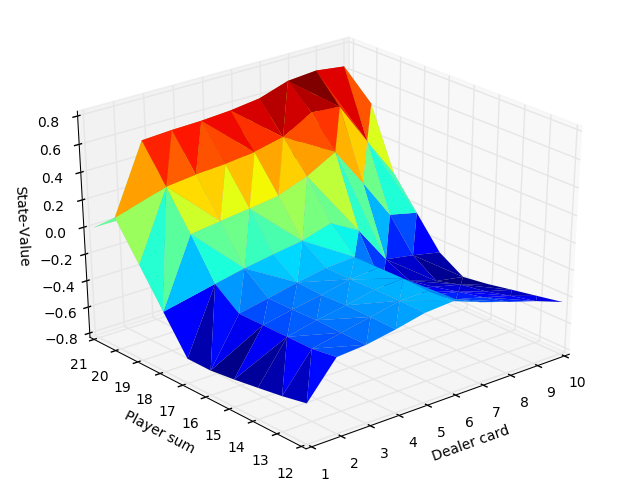

In [50]:
#3d plot of state-value space where no useable Aces are present
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d', )

ax.set_xlabel('Dealer card')
ax.set_ylabel('Player sum')
ax.set_zlabel('State-Value')

x,y,z = [],[],[]
for key in state_space:
    if (not key[1] and key[0] > 11 and key[2] < 21):
        y.append(key[0])
        x.append(key[2])
        state_value = max([av_table[(key, 0)], av_table[(key, 1)]])
        z.append(state_value)
ax.azim = 230
ax.plot_trisurf(x,y,z, linewidth=.02, cmap=cm.jet)

In [52]:
av_table

{((11, False, 1), 0): -0.7551020408163256,
 ((11, False, 1), 1): -0.11564367707048596,
 ((11, False, 2), 0): -0.27663384064458363,
 ((11, False, 2), 1): 0.21543148174591858,
 ((11, False, 3), 0): -0.19419237749546267,
 ((11, False, 3), 1): 0.2358648377383723,
 ((11, False, 4), 0): -0.18134715025906728,
 ((11, False, 4), 1): 0.2740015360983102,
 ((11, False, 5), 0): -0.13422818791946306,
 ((11, False, 5), 1): 0.29799914857386084,
 ((11, False, 6), 0): -0.12858312858312856,
 ((11, False, 6), 1): 0.31069247881857265,
 ((11, False, 7), 0): -0.48387096774193494,
 ((11, False, 7), 1): 0.256389471676523,
 ((11, False, 8), 0): -0.5453744493392072,
 ((11, False, 8), 1): 0.20956194065002362,
 ((11, False, 9), 0): -0.5742753623188404,
 ((11, False, 9), 1): 0.13625047874377683,
 ((11, False, 10), 0): -0.5651777575205135,
 ((11, False, 10), 1): 0.04750517904705545,
 ((11, True, 1), 0): 0.6370851370851357,
 ((11, True, 1), 1): -0.12461059190031155,
 ((11, True, 2), 0): 0.8824884792626707,
 ((11, Tru